# Joint-Action Q-Learning: observation length of one

In [1]:
# import general libraries
import numpy as np
import os
from scipy.signal import periodogram
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import QLearningAgent
from multiplayer_prisoners_dilemma import FreqAdjustedQLearningAgent
from multiplayer_prisoners_dilemma import FixedAgent
from multiplayer_prisoners_dilemma import TitForTatAgent
from multiplayer_prisoners_dilemma import SarsaAgent
from multiplayer_prisoners_dilemma import ExpSarsaAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    action_tuple = tuple(action_vector)
    S, P, R, T = 0, 1, 3, 5
    reward_matrix = {
            (0, 0): (R, R),  # Both cooperate
            (0, 1): (S, T),  # Agent A cooperates, agent B defects
            (1, 0): (T, S),  # Agent A defects, agent B cooperates
            (1, 1): (P, P),  # Both defect
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# game parameters
num_players = 2
action_space = np.array([0 ,  1], dtype=float) # (0 = defect, 1 = cooperate)
observation_length = 1 # number of previous actions that are considered in the observation vector (0 = only current action)
use_prefactor = False

# plot parameters
figsize = (6,6)
dpi = 200
color_list = ['C0', 'C1']
filetype = 'pdf'
save_fig = True

# Q-learning vs Q-learning

In [2]:
# define the agents
agent_pair = [QLearningAgent, QLearningAgent]
observation_length = 1
discount_factor = 0.8
learning_rate = 0.01
selection_method = "Boltzmann" 
temperature = 1
initial_q_tables = [np.array([[0, 0], 
                              [0, 0], 
                              [0, 0], 
                              [0, 0]], dtype=float) for i in range(num_players)]

# Create a list of agents
agents = [agent_pair[i](player_id = i, # define the agents
                action_space = action_space,
                num_players = num_players,
                discount_factor = discount_factor,
                observation_length = observation_length,
                selection_method = selection_method,
                reward_func = reward_matrix_for_two_player_PD,
                temperature = temperature,
                learning_rate = learning_rate,
                q_table = initial_q_tables[i],
                use_prefactor = use_prefactor
                )       
                for i in range(num_players)]

# Create a game and a Simulation
game = Game(agents = agents)
simulation = Simulation()
# length of the time series
num_time_steps = int(1e1)

# run once 
simulation.run(game, agents, num_time_steps) 

# store probability histories
policy_history_of_agent1 = [agents[0].get_action_probabilities(q_table) for q_table in agents[0].q_table_history]
policy_history_of_agent2 = [agents[1].get_action_probabilities(q_table) for q_table in agents[1].q_table_history]

In [3]:
# cell to store the data for reproducibility of the results if wanted
if False:
    # make directory to store the data for reproducibility of the results if not already existing
    directory = os.path.join("data", "IteratedPrisonersDilemma", f"QLearning_{num_time_steps}_steps_{discount_factor}_discount_factor_{learning_rate}_learning_rate_{temperature}_temperature")
    if not os.path.exists(directory):
        os.makedirs(directory)
    # save the policy history of the agents
    np.save(os.path.join(directory, "policy_history_of_agent1.npy"), policy_history_of_agent1)
    np.save(os.path.join(directory, "policy_history_of_agent2.npy"), policy_history_of_agent2)

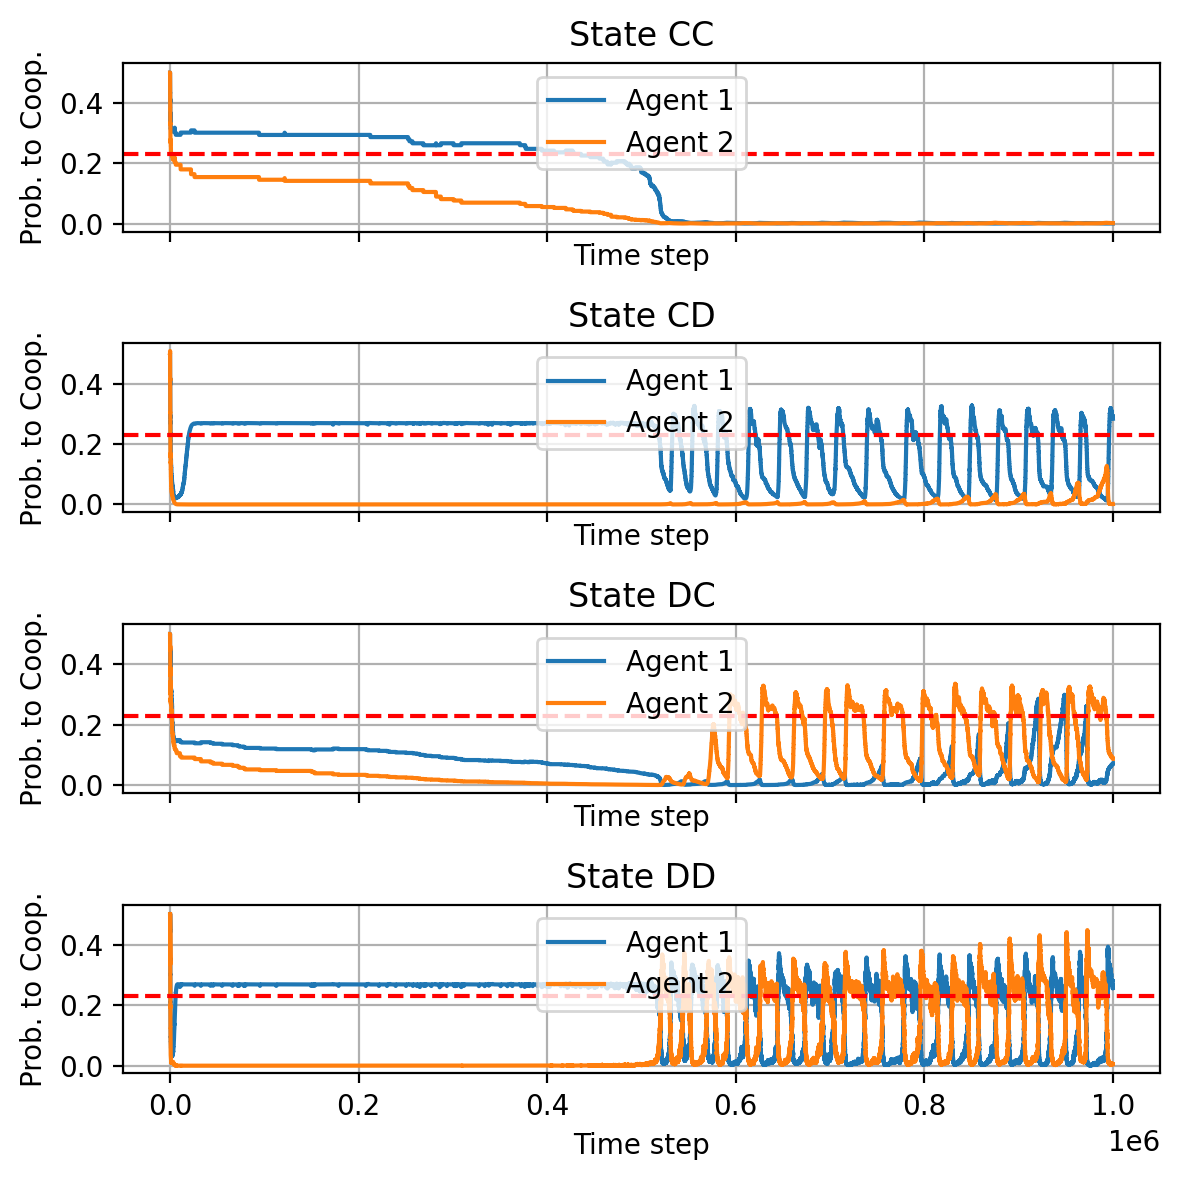

In [4]:
# load data to reproduce certain results if wanted, otherwise plot the results generated above
if True: 
    num_time_steps = int(1e6)
    discount_factor = discount_factor
    learning_rate = learning_rate
    temperature = temperature
    directory = os.path.join("data", "IteratedPrisonersDilemma", f"QLearning_{num_time_steps}_steps_{discount_factor}_discount_factor_{learning_rate}_learning_rate_{temperature}_temperature")
    policy_history_of_agent1 = np.load(os.path.join(directory, "policy_history_of_agent1.npy"))
    policy_history_of_agent2 = np.load(os.path.join(directory, "policy_history_of_agent2.npy"))

# create a figure that shows the policy space of all states as subplots
fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=figsize, dpi=dpi)
states = ['CC', 'CD', 'DC', 'DD']
for state in range(np.shape(policy_history_of_agent1)[1]):
    probabilities_to_cooperate_agent1 = np.array([policy[state][0] for policy in policy_history_of_agent1])
    probabilities_to_cooperate_agent2 = np.array([policy[state][0] for policy in policy_history_of_agent2])
    ax[state].plot(probabilities_to_cooperate_agent1, label = 'Agent 1')
    ax[state].plot(probabilities_to_cooperate_agent2, label = 'Agent 2')
    ax[state].set_title('State ' + states[state])
    ax[state].set_xlabel('Time step')
    ax[state].set_ylabel('Prob. to Coop.')
    #ax[state].set_ylim(-0.01, 1.01)
    # set x-ticks to scientific format
    ax[state].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # plot horizontal line at 0.23
    ax[state].axhline(0.23, color='red', linestyle='--')
    ax[state].legend(loc='upper center')
    ax[state].grid()
plt.tight_layout()
directory = os.path.join("Figures", "MemoryOne_IteratedPrisonersDilemma")
if not os.path.exists(directory):
        os.makedirs(directory)
if save_fig:
    plt.savefig(os.path.join(directory, f"QLearning_{num_time_steps}_steps_{discount_factor}_discount_factor_{learning_rate}_learning_rate_{temperature}_temperature_policy_space.{filetype}"), dpi=dpi, bbox_inches='tight')
plt.show()

# Freq.Adj.QL vs Freq.Adj.QL 

In [5]:
# define the agents
agent_pair = [FreqAdjustedQLearningAgent, FreqAdjustedQLearningAgent]
observation_length = 1
discount_factor = 0.8
learning_rate = 0.01
selection_method = "Boltzmann" 
temperature = 1
initial_q_tables = [np.array([[0, 0], 
                              [0, 0], 
                              [0, 0], 
                              [0, 0]], dtype=float) for i in range(num_players)]

# Create a list of agents
agents = [agent_pair[i](player_id = i, 
                action_space = action_space,
                num_players = num_players,
                discount_factor = discount_factor,
                observation_length = observation_length,
                selection_method = selection_method,
                reward_func = reward_matrix_for_two_player_PD,
                temperature = temperature,
                learning_rate = learning_rate,
                q_table = initial_q_tables[i],
                use_prefactor = use_prefactor
                )       
                for i in range(num_players)]

# Create a game and a Simulation
game = Game(agents = agents)
simulation = Simulation()
# length of the time series
num_time_steps = int(4e1)

# run once 
simulation.run(game, agents, num_time_steps) 

# store probability histories
policy_history_of_agent1 = [agents[0].get_action_probabilities(q_table) for q_table in agents[0].q_table_history]
policy_history_of_agent2 = [agents[1].get_action_probabilities(q_table) for q_table in agents[1].q_table_history]

In [6]:
# cell to store the data for reproducibility of the results if wanted
if False:
    # make directory to store the data for reproducibility of the results if not already existing
    directory = os.path.join("data", "IteratedPrisonersDilemma", f"FrequencyAdjustedQLearning_{num_time_steps}_steps_{discount_factor}_discount_factor_{learning_rate}_learning_rate_{temperature}_temperature")
    if not os.path.exists(directory):
        os.makedirs(directory)
    # save the policy history of the agents
    np.save(os.path.join(directory, "policy_history_of_agent1.npy"), policy_history_of_agent1)
    np.save(os.path.join(directory, "policy_history_of_agent2.npy"), policy_history_of_agent2)

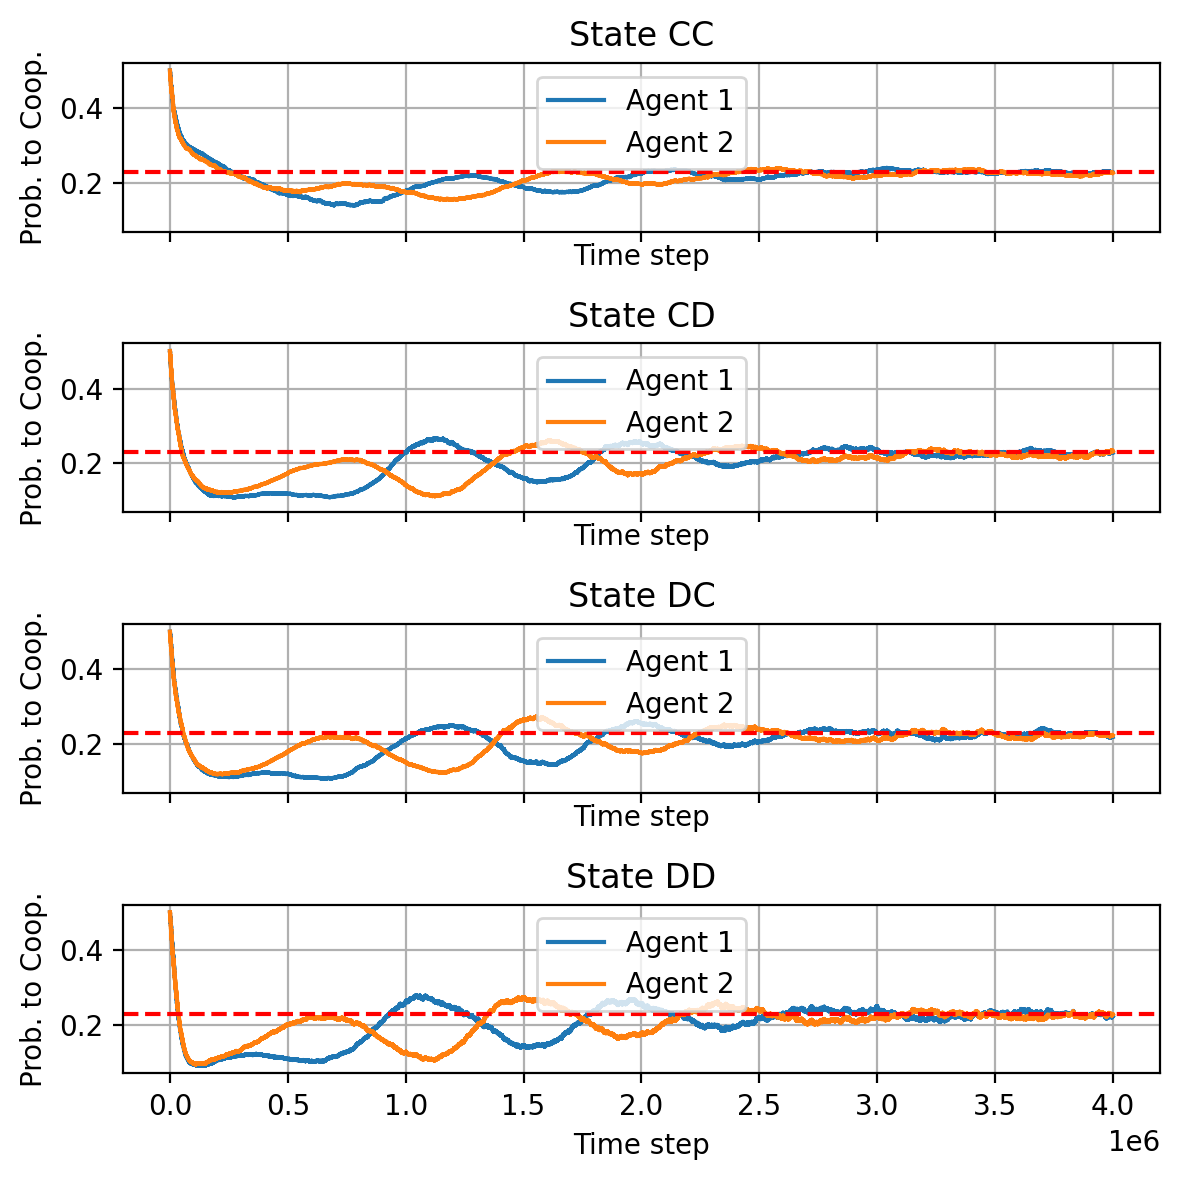

In [7]:
# load data to reproduce certain results if wanted, otherwise plot the results generated above
if True: 
    num_time_steps = int(4e6)
    discount_factor = discount_factor
    learning_rate = learning_rate
    temperature = temperature
    directory = os.path.join("data", "IteratedPrisonersDilemma", f"FrequencyAdjustedQLearning_{num_time_steps}_steps_{discount_factor}_discount_factor_{learning_rate}_learning_rate_{temperature}_temperature")
    policy_history_of_agent1 = np.load(os.path.join(directory, "policy_history_of_agent1.npy"))
    policy_history_of_agent2 = np.load(os.path.join(directory, "policy_history_of_agent2.npy"))

# create a figure that shows the policy space of all states as subplots
fig, ax = plt.subplots(4, sharex=True, sharey=True, figsize=figsize, dpi=dpi)
states = ['CC', 'CD', 'DC', 'DD']
for state in range(np.shape(policy_history_of_agent1)[1]):
    probabilities_to_cooperate_agent1 = np.array([policy[state][0] for policy in policy_history_of_agent1])
    probabilities_to_cooperate_agent2 = np.array([policy[state][0] for policy in policy_history_of_agent2])
    ax[state].plot(probabilities_to_cooperate_agent1, label = 'Agent 1')
    ax[state].plot(probabilities_to_cooperate_agent2, label = 'Agent 2')
    ax[state].set_title('State ' + states[state])
    ax[state].set_xlabel('Time step')
    ax[state].set_ylabel('Prob. to Coop.')
    # plot horizontal line at 0.23
    ax[state].axhline(0.23, color='red', linestyle='--')
    #ax[state].set_ylim(-0.01, 1.01)
    ax[state].legend(loc='upper center')
    ax[state].grid()
plt.tight_layout()
directory = os.path.join("Figures", "MemoryOne_IteratedPrisonersDilemma")
if not os.path.exists(directory):
        os.makedirs(directory)
if save_fig:
    plt.savefig(os.path.join(directory, f"FAQLearning_{num_time_steps}_steps_{discount_factor}_discount_factor_{learning_rate}_learning_rate_{temperature}_temperature_policy_space.jpg"), dpi=dpi, bbox_inches='tight')
plt.show()